In [6]:
import warnings
import itertools

import numpy as np
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.forecasting.model_selection import (
    ForecastingRandomizedSearchCV,
    ExpandingWindowSplitter,
)
from sktime.utils.plotting import plot_series

# SARIMAX
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.stream import UpdateEvery

from src.data import load_train_test
from src import get_config, plot_windows, get_rolling_predictions

In [7]:
config = get_config()
train, test = load_train_test(config.processed_data_path)

# Filter train data to use oly data since september 2022
train = train[train.index >= "2022-09-01"]

target_column = str(config.target_station_id)
train_target_series = train[target_column]
test_target_series = test[target_column]

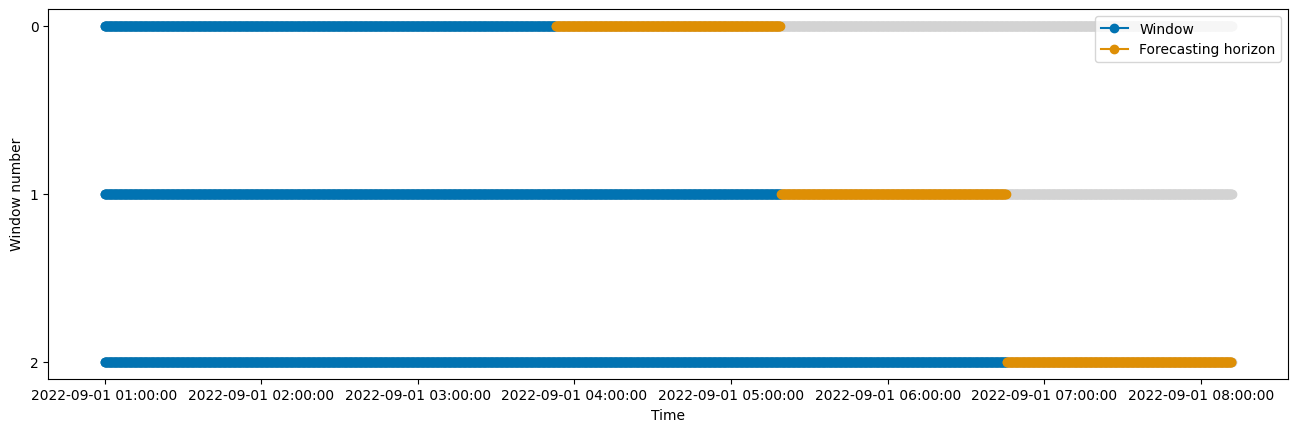

In [8]:
ONE_MONTH = 24 * 30
fh = np.arange(1, ONE_MONTH // 2)
cv = ExpandingWindowSplitter(
    fh=fh,
    initial_window=ONE_MONTH,
    step_length=ONE_MONTH // 2,
)
plot_windows(cv, train_target_series)

In [9]:
possible_p_values = [
    0,
    1,
    2,
    3,
    4,
    7,
    9,
    11,
    15,
    19,
    22,
    24,
    26,
    30,
    35,
    40,
    48,
    56,
]
possible_i_values = [0]
possible_q_values = [1, 2, 3, 24, 25]
possible_P_values = [0, 1, 2, 3]
possible_I_values = [0]
possible_Q_values = [1, 2]
possible_s_values = [24, 24 * 7]

possible_orders = [
    (p, i, q)
    for p in possible_p_values
    for i in possible_i_values
    for q in possible_q_values
]
possible_seasonal_orders = [
    (P, I, Q, s)
    for P in possible_P_values
    for I in possible_I_values
    for Q in possible_Q_values
    for s in possible_s_values
]


PARAMETER_GRID = {
    "order": possible_orders,
    "seasonal_order": possible_seasonal_orders,
}

forecaster = ForecastingRandomizedSearchCV(
    SARIMAX(enforce_invertibility=False, enforce_stationarity=False),
    cv=cv,
    n_iter=1,
    param_distributions=PARAMETER_GRID,
    strategy="no-update_params",
    n_jobs=4,
    scoring=mean_squared_error,
    verbose=1,
)

In [10]:
warnings.filterwarnings("ignore")
forecaster.fit(train_target_series)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/pablo/.cache/pypoetry/virtualenvs/src--eE-fv8V-py3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [ ]:
fh = np.arange(1, 25)
best_model = SARIMAX(**forecaster.best_params_)
best_model = UpdateEvery(best_model, update_interval=24)
best_model.fit(train_target_series, fh=fh)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04675D+00    |proj g|=  3.33986D+00

At iterate    5    f=  2.60498D+00    |proj g|=  7.64817D-02

At iterate   10    f=  2.59510D+00    |proj g|=  1.78185D-02

At iterate   15    f=  2.59445D+00    |proj g|=  3.05794D-03

At iterate   20    f=  2.59344D+00    |proj g|=  1.16030D-02

At iterate   25    f=  2.59174D+00    |proj g|=  4.16081D-03

At iterate   30    f=  2.59118D+00    |proj g|=  8.49622D-03

At iterate   35    f=  2.59103D+00    |proj g|=  1.97166D-03

At iterate   40    f=  2.59100D+00    |proj g|=  2.23873D-03

At iterate   45    f=  2.59092D+00    |proj g|=  8.68492D-03

At iterate   50    f=  2.59042D+00    |proj g|=  1.25558D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

UpdateEvery(forecaster=SARIMAX(order=(3, 0, 3), seasonal_order=(2, 0, 2, 24)),
            update_interval=24)

In [ ]:
predictions = best_model.update_predict(
    test_target_series, update_params=False
)
predictions

ValueError: Prediction must have `end` after `start`.

In [ ]:
best_params = forecaster.best_params_
title = f"Resutados de SARIMAX({best_params['order']}, {best_params['seasonal_order']}) con actualización cada 24 horas"
plot_series(train_target_series, test_target_series, predictions, labels=["train", "test", "predictions"], title=title, y_label="Ocupación")

AttributeError: 'ForecastingGridSearchCV' object has no attribute 'best_params_'

In [ ]:
mean_squared_percentage_error(test_target_series[:-1], predictions)

3.1968257270297463e+30

In [ ]:
mean_squared_error(test_target_series[:-1], predictions)

9.544604574305607

In [ ]:
# Save csv with results
forecaster.cv_results_.to_csv(
    os.path.join(config.processed_data_path, "sarimax_rolling_cv_results.csv")
)

,mean_test__DynamicForecastingErrorMetric,mean_fit_time,mean_pred_time,params,rank_test__DynamicForecastingErrorMetric
0,4.245721e+31,0.600116,0.022936,"{'order': (0, 0, 1), 'seasonal_order': (0, 0, ...",1.0
